In [5]:
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import StandardScaler
import pyreadr
from changepoint_online import NPFocus
from concurrent.futures import ProcessPoolExecutor
from itertools import islice, cycle
import regex as re

In [6]:
# Read in the Data
net1 = pyreadr.read_r("data/sum_net1.rds")[None]
net2 = pyreadr.read_r("data/sum_net2.rds")[None]

diff = net2.ts.min() - net1.ts.max()

# Transform the net1 timestamp so that phase 2 begins immediately after phase 1
net1["ts"] = net1["ts"] + diff

# Concatenate the two phases into 1 dataframe
orig_dat = pd.concat([net1, net2])

# Delete the old dataframes from memory
del net1, net2

# Run Changepoint on Aggregated Data

In [10]:
# Create "Minutes" variable from Timestamp
orig_dat["minutes"] = orig_dat["ts"] \
    .apply(datetime.fromtimestamp, tz = timezone.utc) \
    .apply(lambda x : x.strftime("%Y-%m-%d %H:%M")) \
    .apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M"))

label_cols = [i for i in orig_dat.columns if bool(re.search(r"[Ll]abel", i))]

proc_dat = orig_dat \
    .drop("direction", axis=1) \
    .groupby(["minutes"]) \
    .sum() \
    .reset_index() \
    .drop(label_cols, axis=1) \
    .sort_values(by = "minutes") \
    .reset_index()

In [11]:
# proc_dat = pd.read_feather("data/proc_dat.feather").reset_index()

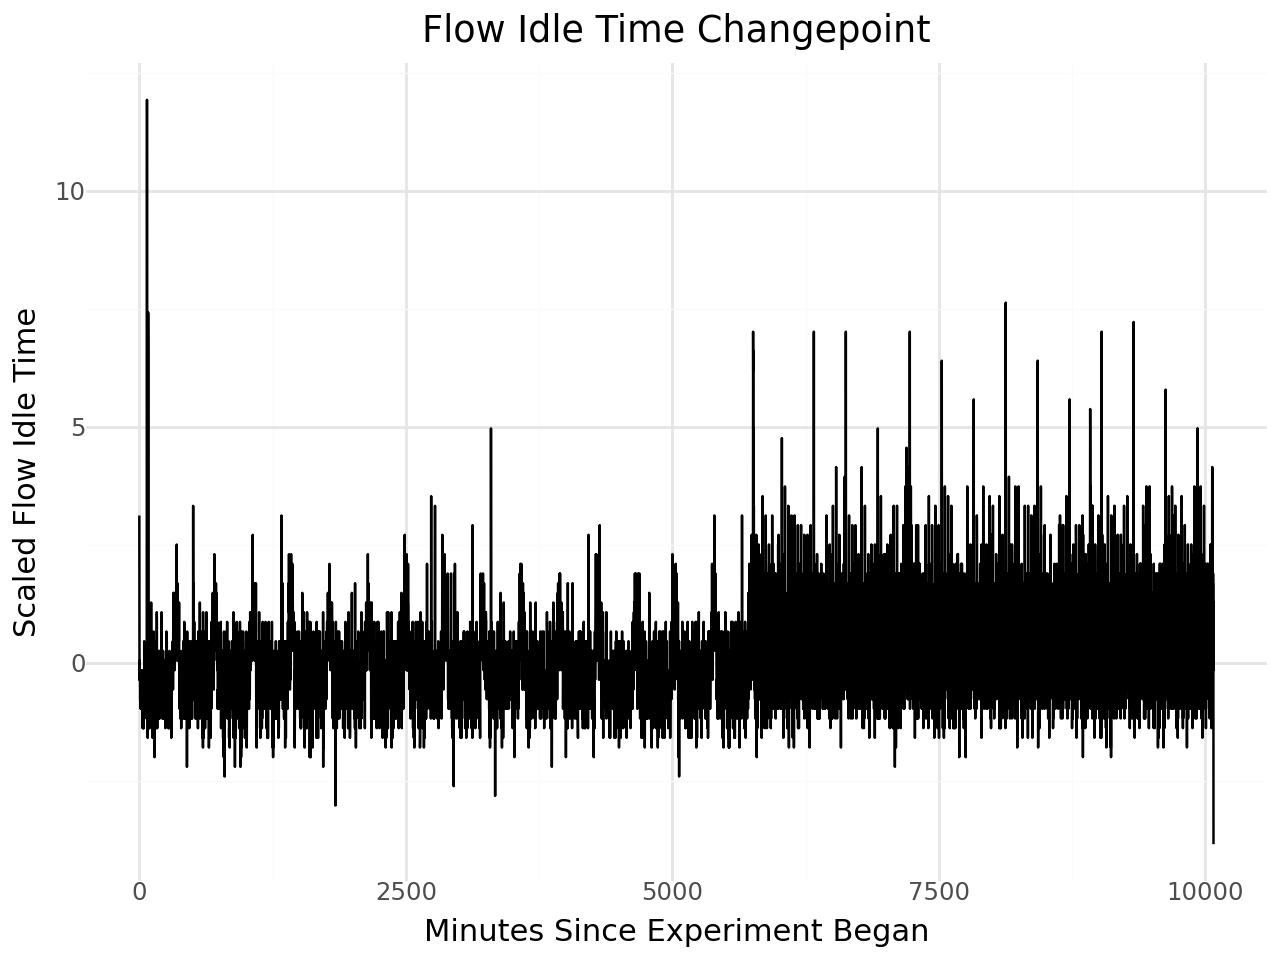

In [12]:
proc_dat["scaled_flow_idle_time"]  = (proc_dat["flow_idle_time"] - proc_dat["flow_idle_time"].mean()) / proc_dat["flow_idle_time"].std()

ggplot(proc_dat) \
+ geom_line(aes(x = "index", y = "scaled_flow_idle_time")) \
+ theme_minimal() \
+ labs(
    title = "Flow Idle Time Changepoint",
    x = "Minutes Since Experiment Began",
    y = "Scaled Flow Idle Time"
)

In [13]:
Y = proc_dat["flow_idle_time"]

quantiles = [np.quantile(Y[:1000], q) for q in [0.25, 0.5, 0.75]]

detector = NPFocus(quantiles)

for y in Y:
  detector.update(y)

  if np.sum(detector.statistic()) > 500:  # Example stopping rule (adjustable)
    break

changepoint_info = detector.changepoint()
print(changepoint_info["stopping_time"],changepoint_info["changepoint"])
agg_stopping_time = changepoint_info["stopping_time"]
agg_changepoint = changepoint_info["changepoint"]

7829 5718


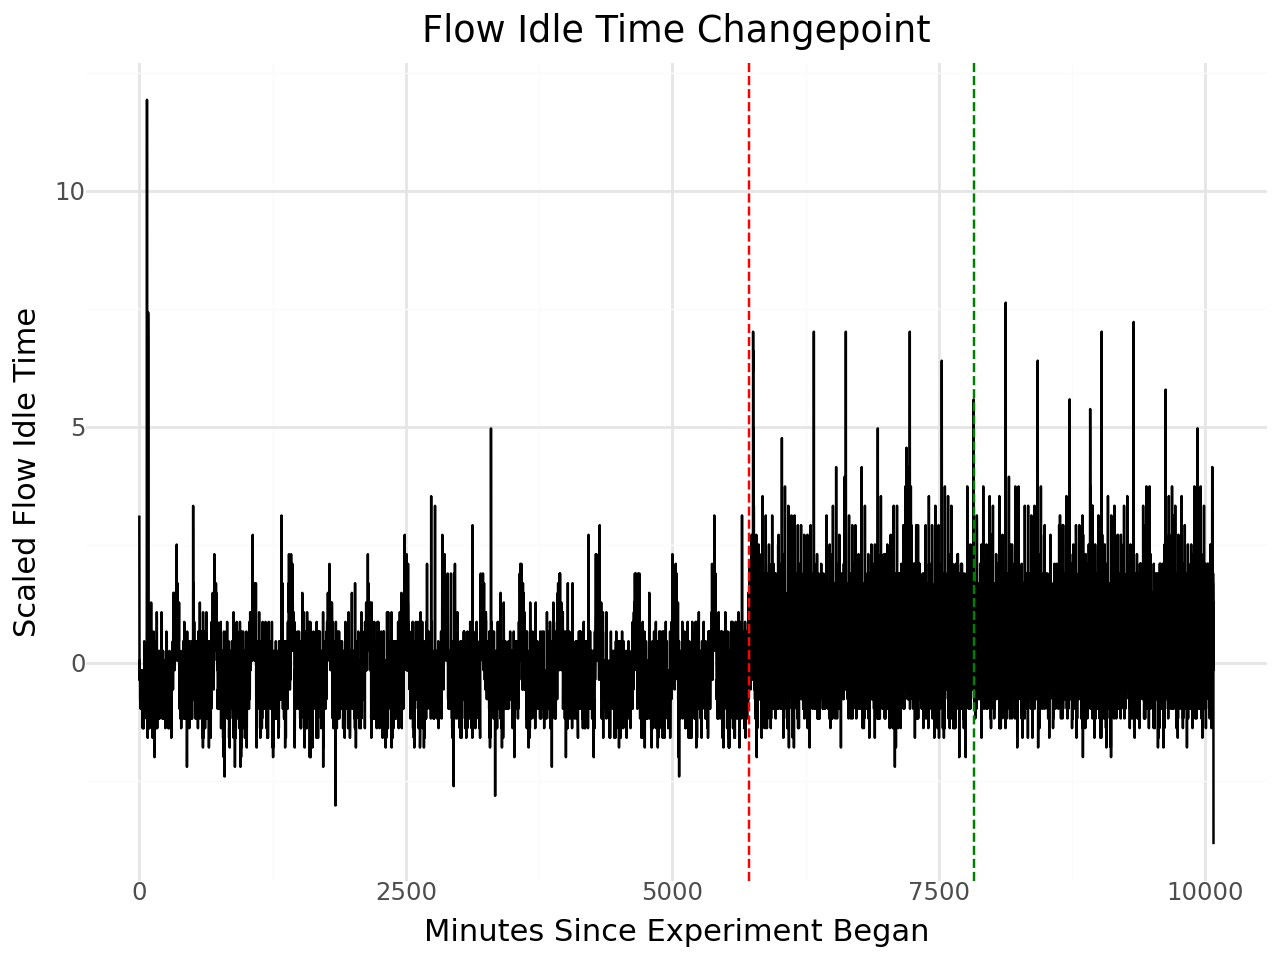

In [14]:
ggplot(proc_dat) \
+ geom_line(aes(x = "index", y = "scaled_flow_idle_time")) \
+ geom_vline(xintercept = changepoint_info["changepoint"],
             linetype = "dashed",
             color = "red") \
+ geom_vline(xintercept = changepoint_info["stopping_time"],
             linetype = "dashed",
             color = "green") \
+ theme_minimal() \
+ labs(
    title = "Flow Idle Time Changepoint",
    x = "Minutes Since Experiment Began",
    y = "Scaled Flow Idle Time"
)

# Preprocessing

In [15]:
# Retreive from and to ip addresses
orig_dat[["from", "to"]] = orig_dat["direction"] \
    .str \
    .extract(r"([\d.]+) -> ([\d.]+)")

# Scale the Data
discrete = ["ts", "minutes", "from", "to", "direction"]
scaler = StandardScaler()
scaled = scaler.fit_transform(orig_dat.drop(discrete, axis=1))

col_names = np.array(orig_dat.drop(discrete,axis=1).columns)

orig_scaled = pd.DataFrame(scaled) \
    .rename({num : orig for num, orig in zip(range(scaled.shape[1]), col_names)},
            axis=1)
orig_scaled[discrete] = orig_dat[discrete].reset_index(drop=True)

# Find a Change Points for each IP address

In [16]:
# Find all of the distinct IP Addresses
all_ips = np.unique(np.append(orig_dat["from"], orig_dat["to"]))

# Find out the total number of minutes
mins = orig_scaled[["minutes"]].groupby("minutes").mean().reset_index()

The idea is to throw up a flag every time that there is a changepoint detected and then if a changepoint is detected in the aggregated data, we compare the values of each one and determine which IP addresses are the most likely to be malicious.

In [17]:
# Pretend as if all of these were running simulataneously

var = "flow_idle_time" # Insert variable of interest

results = {
"IP_Address" : [],
"stopping_time" : [],
"changepoint" : []
}

stat_over_time = {
    "IP_Address" : [],
    "statistic" : []
}
for ip in all_ips:
    # Get the data that we need (All data does not fit in local memory at once)
    dat = orig_dat \
        [((orig_dat["from"] == ip) | (orig_dat["to"] == ip))] \
        .sort_values(by = "minutes") \
        [["minutes", var]]
    
    Y = pd.merge(mins, dat, how="left") \
        .fillna(0) \
        .groupby("minutes") \
        .sum() \
        .reset_index() \
        [var]

    # Implement Changepoint detection
    quantiles = [np.quantile(Y[:1000], q) for q in [0.25, 0.5, 0.75]]

    detector = NPFocus(quantiles)
    itr = 0
    for y in Y:
        detector.update(y)

        stat_over_time["IP_Address"].append(ip)
        stat_over_time["statistic"].append(np.sum(detector.statistic()))
        if np.sum(detector.statistic()) > 136:  # Example stopping rule (adjustable)
            changepoint_info = detector.changepoint()

            # Add changepoint to results dictionary
            results["IP_Address"].append(ip)
            results["stopping_time"].append(changepoint_info["stopping_time"])
            results["changepoint"].append(changepoint_info["changepoint"])

            # Change the reference Distribution
            # if itr > 1000:
            #     quantiles = [np.quantile(Y[(itr-1000):itr], q) for q in [0.25, 0.5, 0.75]]
            #     detector = NPFocus(quantiles)
        itr += 1

In [18]:
# Make a dataframe from the detector statistic over time and results
stat_df = pd.DataFrame(stat_over_time)
stat_df["time"] = pd.Series(islice(cycle(range(10078)), stat_df.shape[0]))
results = pd.DataFrame(results)

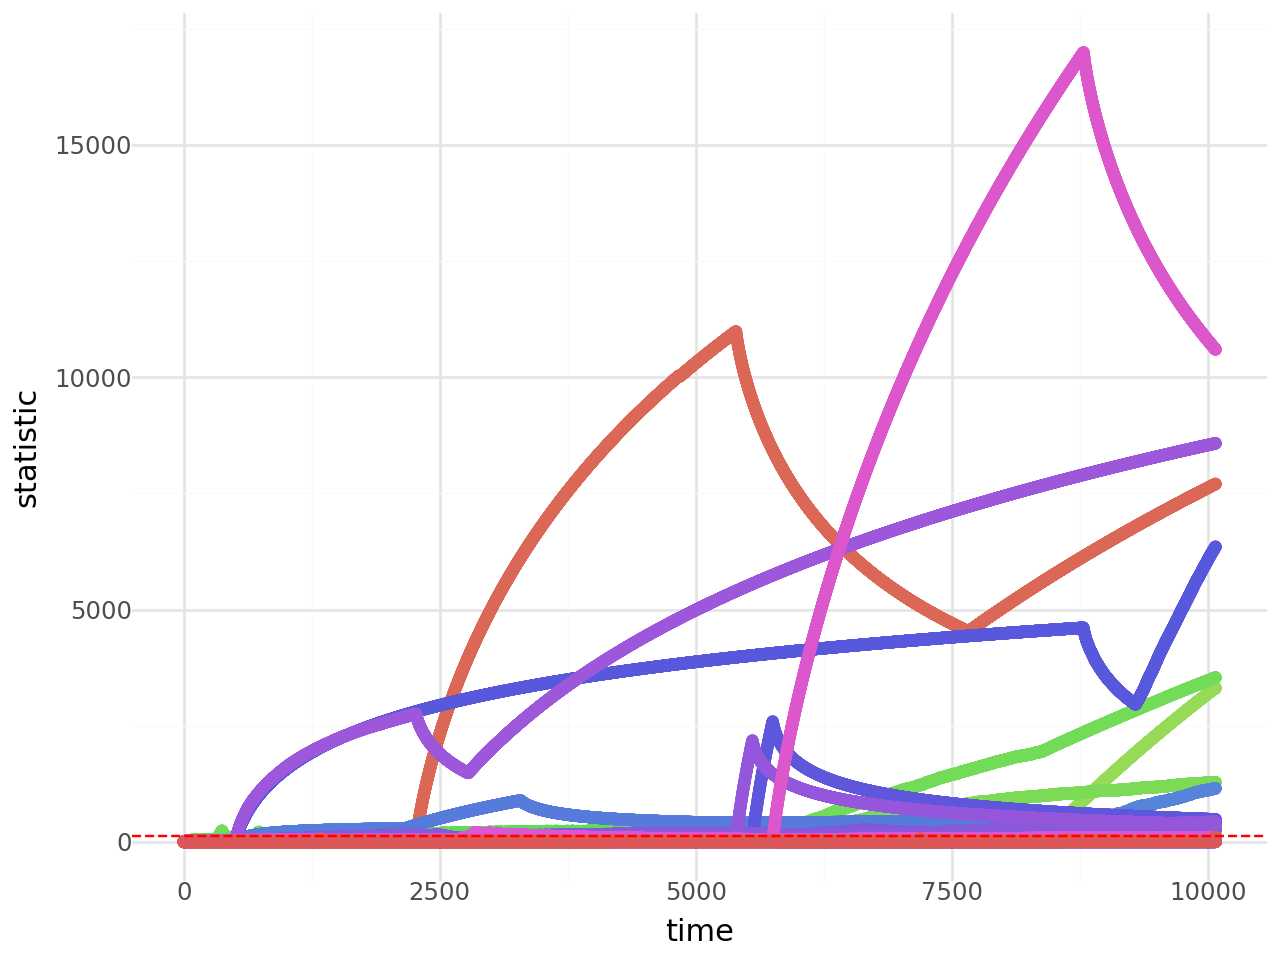

In [19]:
# Visualize Statistic Over time
ggplot(stat_df[stat_df["IP_Address"] != "0"]) \
+ geom_point(aes(x = "time", y = "statistic", color = "IP_Address")) \
+ geom_hline(yintercept = 136,
             linetype = "dashed",
             color = "red") \
+ theme_minimal() \
+ theme(legend_position="none")

# Find Suspected IP Addresses

In [20]:
# Filter to only results that were obtained before the stopping time
results = results \
    [results["stopping_time"] <= agg_stopping_time] \
    .groupby(["IP_Address", "changepoint"]) \
    .min() \
    .reset_index()

In [21]:
# Find absolute value of the difference to determine which changepoints were closest to the aggregated changepoint
results.loc[:,"abs_diff"] = (results.loc[:,"changepoint"] - agg_changepoint).abs()

# Sort by abs_diff
results = results \
    .sort_values("abs_diff") \
    .reset_index(drop = True)

suspected_IP = results.loc[:8,"IP_Address"]
results.head()

,IP_Address,changepoint,stopping_time,abs_diff
0,172.16.65.1,5718,5756,0
1,172.16.65.128,5718,5764,0
2,172.16.65.128,5717,5776,1
3,172.16.65.1,5717,5859,1
4,172.16.65.1,5713,5925,5


# Visualize Results

In [22]:
# Obtain the necessary Data
sus_dat = pd.DataFrame()
for ip in suspected_IP.unique():
    # Get the data that we need (All data does not fit in local memory at once)
    dat = orig_dat \
        [((orig_dat["from"] == ip) | (orig_dat["to"] == ip))] \
        .sort_values(by = "minutes") \
        [["minutes", var]]
    
    Y = pd.merge(mins, dat, how="left") \
        .fillna(0) \
        .groupby("minutes") \
        .sum() \
        .reset_index() \
        .reset_index()
    Y["IP"] = ip
    sus_dat = pd.concat([sus_dat, Y])

sus_dat["flow_idle_time"] = (sus_dat["flow_idle_time"] - sus_dat["flow_idle_time"].mean()) / sus_dat["flow_idle_time"].std()

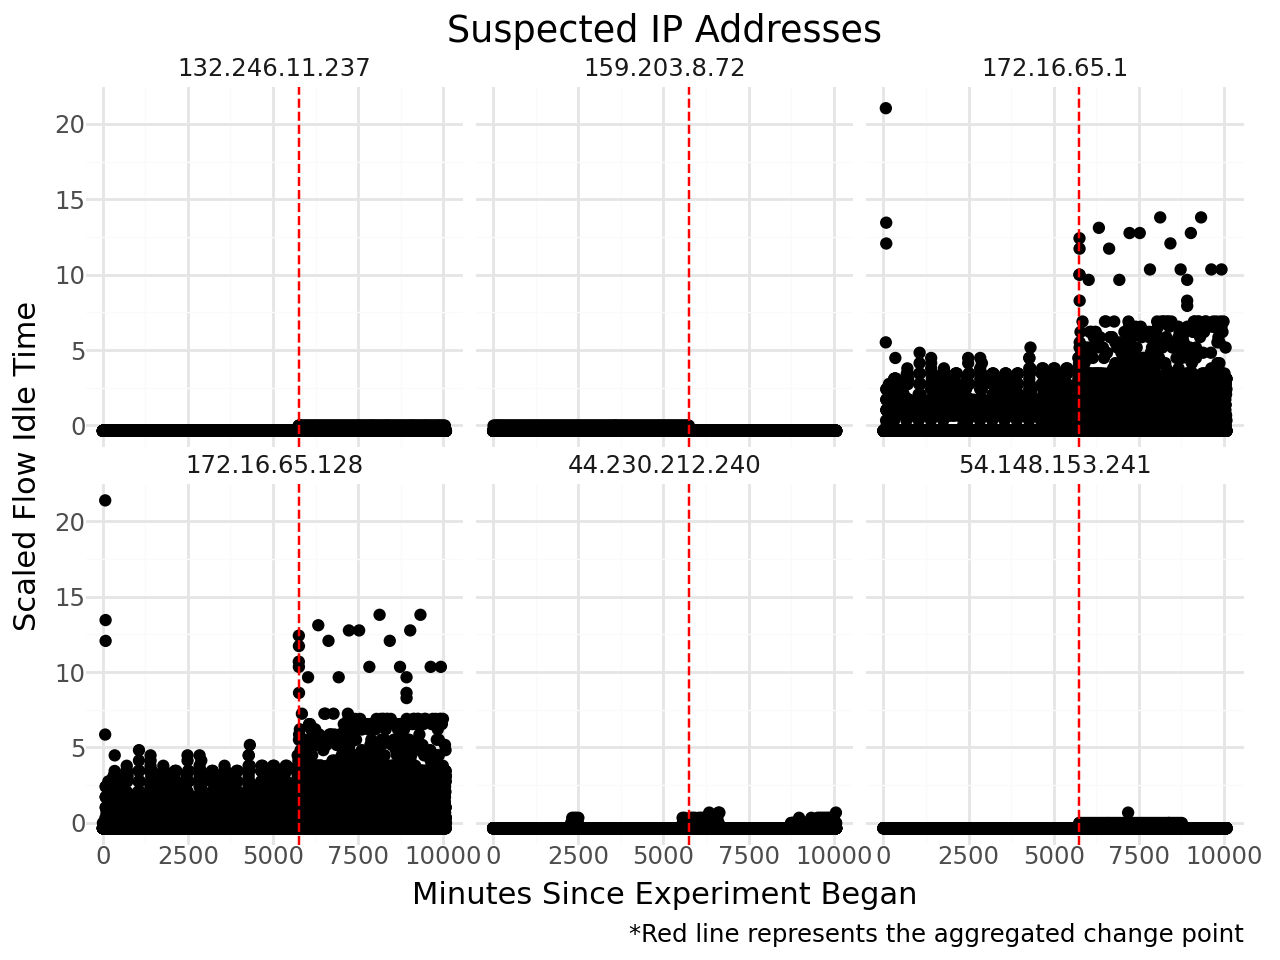

In [23]:
ggplot(sus_dat, aes(x = "index", y = "flow_idle_time")) \
+ geom_point() \
+ facet_wrap("~IP") \
+ geom_vline(xintercept = changepoint_info["changepoint"],
             linetype = "dashed",
             color = "red") \
+ theme_minimal() \
+ labs(
    title = "Suspected IP Addresses",
    x = "Minutes Since Experiment Began",
    y = "Scaled Flow Idle Time",
    caption="*Red line represents the aggregated change point"
)

# Conclusion

Based off of this, we can determine that the primary two suspected IP Addresses are 172.16.65.128 and 172.16.65.1